# Evaluate the enrichment of Decipher shared phenotype patients on our ASD-CHD interactome

Update 19-12-12: found all damaging SNVs/indels in DECIPHER, by looking up karyotype for abnormal nervous and cardiovascular systems.  Use this to make an ROC curve

Update 20-04-28: make sure results can be replicated from supplemental tables, add more description

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import random


# latex rendering of text in graphs
import matplotlib as mpl
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

sns.set_style('white')

import sys

% matplotlib inline


# Load the ASD-CHD network genes, (z_ASD-CHD>3; 844 genes)

In [2]:
# see notebook in final_notebooks_190703 for construction of this table

ASD_CHD_df = pd.read_excel('../../manuscript/tables_19_01/supplemental_tables.xlsx',sheet_name='ASD_CHD_network_genes')
ASD_CHD_df.index=ASD_CHD_df['gene']
print(len(ASD_CHD_df))
display(ASD_CHD_df.head())

844


,gene,snv_indel_DECIPHERv9.25,snv_indel_DECIPHERv9.31,small_CNV_less1MB_DECIPHERv9.25,ASD_CHD_DNV,sum_damaging_variants,ASD_HC,CHD_HC,z_ASD,z_CHD,z_both,gtex_heart_percentile_exp,gtex_brain_percentile_exp
gene,,,,,,,,,,,,,
NAA15,NAA15,0.0,0.0,0.0,0.0,0.0,1,1,18.901197,20.892283,394.889167,0.733689,0.620830
PTEN,PTEN,1.0,1.0,0.0,1.0,2.0,1,1,16.395135,18.819067,308.541142,0.896062,0.894637
POGZ,POGZ,3.0,3.0,0.0,1.0,4.0,1,1,14.186540,14.641398,207.710787,0.908309,0.953178
KMT2C,KMT2C,0.0,0.0,0.0,1.0,1.0,1,1,13.462226,14.954173,201.316464,0.873100,0.908995
KDM5B,KDM5B,1.0,1.0,0.0,1.0,2.0,1,1,10.464431,13.490241,141.167693,0.677893,0.698533


In [3]:
# number of dual-phenotype genes harboring at least one damaging variant (from DECIPHER v9.25, SNVs/INDELS/smallCNVs, + PCGC/PHN dual-phenotype dDNVs)
# but MLL2 is included here... set to nan because it is a duplicate of KMT2A in PCnet
sum(ASD_CHD_df['sum_damaging_variants']>0)

174

# Load the DECIPHER karyotype results

DECIPHER karyotype results come from DECIPHER v9.31, and include only damaging SNVs/indels (no CNVs). We were not able to collect CNV information from the DECIPHER karyotype data.


In [4]:
# dec_kary_shared = pd.read_excel('../../manuscript/tables_19_01/DECIPHER_karyotypes.xlsx',sheet_name='ASD-CHD')
dec_kary_shared = pd.read_excel('../../manuscript/tables_19_01/supplemental_tables.xlsx',sheet_name='DECIPHER_ASD_CHD_karyotype')
dec_kary_shared.index=dec_kary_shared['gene']
print(len(dec_kary_shared))
dec_kary_shared.head()

356


,chr,gene,num_damaging_SNVs_indels
gene,,,
GNB1,1,GNB1,1
CAMTA1,1,CAMTA1,1
RERE,1,RERE,2
MTHFR,1,MTHFR,1
MTOR,1,MTOR,1


In [5]:
print(len(dec_kary_shared))
print(sum(dec_kary_shared['num_damaging_SNVs_indels']))
print(sum(dec_kary_shared['num_damaging_SNVs_indels']>1))

356
761
157


Text(0,0.5,'# dual-phenotype variants')

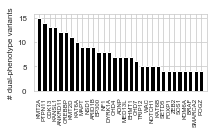

In [6]:
# bar-plot genes harboring most variants
sns.set_style('whitegrid')
dual_plot =ASD_CHD_df[ASD_CHD_df['sum_damaging_variants']>3]['sum_damaging_variants']
dual_plot=dual_plot.sort_values(ascending=False)
plt.figure(figsize=(3.1,1.41))
plt.bar(np.arange(len(dual_plot)),dual_plot,color='black')
tmp=plt.xticks(np.arange(len(dual_plot)),dual_plot.index.tolist(),fontsize=6,rotation='vertical',va='top')
plt.xlim([-1,len(dual_plot)])
plt.yticks([0,5,10,15],fontsize=8)
plt.ylabel('# dual-phenotype variants',fontsize=8)
# plt.savefig('../../manuscript/figures_1911/Figure3/barchart_dualpheno_g2.png',dpi=300,bbox_inches='tight')
# plt.savefig('../../manuscript/figures_1911/Figure3/barchart_dualpheno_g2.pdf',dpi=300,bbox_inches='tight')
# plt.savefig('../../manuscript/figures_1911/Figure3/barchart_dualpheno_g2.svg',dpi=300,bbox_inches='tight')


# Make a chart of the known/novel genes

In [7]:
gene_classification = pd.read_excel('../../manuscript/tables_19_01/supplemental_tables.xlsx',
                                    sheet_name='lit_review_replicated_genes')
gene_classification.index=gene_classification['Gene symbol']
gene_classification.head()

,Gene symbol,num variants replicated,ASD seed,CHD seed,Known NDD,Known CHD,PMID NDD,PMID CHD,NDD notes,CHD nodes,syndrome associated with gene
Gene symbol,,,,,,,,,,,
ACTB,ACTB,1,0,1.0,weak,seed,"29388391, 29220674",NaN,case reports,NaN,NaN
ADNP,ADNP,7,1,0.0,seed,weak,NaN,29724491,NaN,case reports,NaN
AGO2,AGO2,1,0,0.0,none,none,NaN,NaN,NaN,NaN,NaN
ANK3,ANK3,1,0,1.0,strong,seed,"28411148, 28687526",NaN,"mouse KO, case reports",NaN,NaN
ANKIB1,ANKIB1,1,0,0.0,none,none,NaN,NaN,NaN,NaN,NaN


In [8]:
gene_classification['Known NDD'].value_counts()

strong    51
none      49
weak      36
seed      24
medium    10
Name: Known NDD, dtype: int64

In [9]:
known_NDD = pd.Categorical(gene_classification['Known NDD'])
known_CHD = pd.Categorical(gene_classification['Known CHD'])

In [10]:
NDD_CHD_crosstab=pd.crosstab(known_NDD, known_CHD,rownames=['NDD'],colnames=['CHD'])
order_temp = ['none','weak','medium','strong','seed']
NDD_CHD_crosstab = NDD_CHD_crosstab[order_temp].loc[order_temp[::-1]]
NDD_CHD_crosstab


CHD,none,weak,medium,strong,seed
NDD,,,,,
seed,10,5,2,2,4
strong,15,4,1,17,14
medium,3,0,1,2,4
weak,24,6,0,2,4
none,36,4,0,4,5


(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text yticklabel objects>)

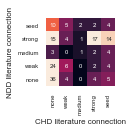

In [11]:
plt.figure(figsize=(1.25,1.25))
hfig = sns.heatmap(NDD_CHD_crosstab,annot=True,cbar=False,annot_kws={"size": 6},vmin=0,vmax=15)
plt.ylabel('NDD literature connection',fontsize=8)
plt.xlabel('CHD literature connection',fontsize=8)
plt.xticks(fontsize=6,rotation='vertical')
plt.yticks(fontsize=6,rotation='horizontal')
# plt.savefig('../../manuscript/figures_1911/Figure3/known_novel_NDD_CHD.png',dpi=300,bbox_inches='tight')
# plt.savefig('../../manuscript/figures_1911/Figure3/known_novel_NDD_CHD.svg',dpi=300,bbox_inches='tight')
# plt.savefig('../../manuscript/figures_1911/Figure3/known_novel_NDD_CHD.pdf',dpi=300,bbox_inches='tight')

# DECIPHER ROC curves

In [12]:
# load the full z-score results for ASD and CHD

z_ASD = pd.read_excel('../../manuscript/tables_19_01/supplemental_tables.xlsx',sheet_name='z_ASD',
                    names=['gene','zscore'],index_col='gene')
z_CHD = pd.read_excel('../../manuscript/tables_19_01/supplemental_tables.xlsx',sheet_name='z_CHD',
                    names=['gene','zscore'],index_col='gene')

z_ASD.head()

# multiply by the sign (+1 if both +, -1 if either -). 
z_ASDCHD = z_ASD['zscore'].abs()*z_CHD['zscore'].abs()*(((np.sign(z_ASD['zscore'])>0)&(np.sign(z_CHD['zscore'])>0))*1.0-.5)*2


z_ASDCHD.head()



seed_genes = ASD_CHD_df[(ASD_CHD_df['ASD_HC']==1)|(ASD_CHD_df['CHD_HC']==1)].index.tolist()
print(len(seed_genes))
non_seed_genes = list(np.setdiff1d(z_ASDCHD.index.tolist(),seed_genes))
z_ASDCHD_noseeds = z_ASDCHD.loc[non_seed_genes]
print(len(z_ASDCHD_noseeds))
z_ASDCHD_noseeds.max()

z_comb = z_ASD.join(z_CHD,lsuffix='_ASD',rsuffix='_CHD')
z_comb['zprod_both']=z_ASDCHD
z_comb.head()

z_comb_no_seeds = z_comb.loc[non_seed_genes]
z_comb_no_seeds.head()

80
19701


,zscore_ASD,zscore_CHD,zprod_both
gene,,,
A1BG,-1.483328,0.316803,-0.469922
A1CF,-0.927115,0.571386,-0.529741
A2M,-2.837494,0.598259,-1.697556
A2ML1,-1.119579,1.554647,-1.740550
A3GALT2,-0.807590,3.459356,-2.793741


In [13]:
focal_genes_temp = list(np.intersect1d(z_ASDCHD[z_ASDCHD>3].index.tolist(),dec_kary_shared.index.tolist()))
print(len(focal_genes_temp))
print(dec_kary_shared['num_damaging_SNVs_indels'].loc[focal_genes_temp].dropna().sum())


83
293


In [14]:


def calc_FPR_TPR(z_ASDCHD, both_DECIPHER,thresh_list):

    TP_both_list,FP_both_list,TN_both_list,FN_both_list = [],[],[],[]

#     thresh_list = np.arange(0,30)
#     thresh_list = np.linspace(-17,400,1000)
#     thresh_list = np.linspace(0,2,1000)
    for thresh_temp in thresh_list:

        both_predicted = z_ASDCHD[z_ASDCHD>=thresh_temp].index.tolist()

        # ------ both -------
        num_TP_both = len(np.intersect1d(both_DECIPHER,both_predicted))
        num_FP_both = len(both_predicted)-num_TP_both
        num_FN_both = len(both_DECIPHER)-num_TP_both
        # number true negatives is everything that wasn't TP, FN, or FP
        num_TN_both = len(z_ASDCHD)-num_TP_both-num_FP_both-num_FN_both 

        TP_both_list.append(num_TP_both)
        FP_both_list.append(num_FP_both)
        TN_both_list.append(num_TN_both)
        FN_both_list.append(num_FN_both)

        # P is number of true positives in the data
        P_both = len(both_DECIPHER)
        # N is number of true negatives in the data (# number of interactome genes- P..?)
        N_both = len(z_ASDCHD)-P_both 
        # (TPR = sensitivity/ recall)
        TPR_both = np.divide(TP_both_list,float(P_both))
        FPR_both = np.divide(FP_both_list,float(N_both))

        
    return(TPR_both,FPR_both)

In [15]:
# make an ROC curve sweeping z score
from sklearn.metrics import roc_curve,auc
thresh_list = np.linspace(-17,400,2000)

dec_thresh=1
both_DECIPHER = dec_kary_shared[dec_kary_shared['num_damaging_SNVs_indels']>dec_thresh].index.tolist()
print(len(both_DECIPHER))
# make sure the genes are able to be recovered
both_DECIPHER = list(np.intersect1d(z_ASDCHD.index.tolist(),both_DECIPHER))
print(len(both_DECIPHER))

TPR_both,FPR_both=calc_FPR_TPR(z_comb['zprod_both'], both_DECIPHER,thresh_list)

both_DECIPHER_noseeds = list(np.setdiff1d(both_DECIPHER,seed_genes))
print(len(both_DECIPHER_noseeds))
TPR_both_noseeds,FPR_both_noseeds=calc_FPR_TPR(z_comb_no_seeds['zprod_both'], both_DECIPHER_noseeds,thresh_list)
# TPR_both

auc_both = auc(FPR_both,TPR_both)
print(auc_both)
auc_both_noseeds = auc(FPR_both_noseeds,TPR_both_noseeds)
print(auc_both_noseeds)



auc_both_rand=[]
# randomize xeno_df
for r in np.arange(100):
#     print(r)
    if (r%10)==0:
        print(r)

    z_ASDrand = z_ASD.copy(deep=True)
    rand_index=z_ASDrand.index.tolist()
    np.random.shuffle(rand_index)
    z_ASDrand.index=rand_index
    z_CHDrand = z_CHD.copy(deep=True)
    rand_index=z_CHDrand.index.tolist()
    np.random.shuffle(rand_index)
    z_CHDrand.index=rand_index
    z_ASDrand.head()

    z_ASDCHDrand = z_ASDrand['zscore'].abs()*z_CHDrand['zscore'].abs()*(((np.sign(z_ASDrand['zscore'])>0)&(np.sign(z_CHDrand['zscore'])>0))*1.0-.5)*2

    
    TPR_both_rand,FPR_both_rand=calc_FPR_TPR(z_ASDCHDrand, both_DECIPHER,thresh_list)
    auc_both_rand.append(auc(TPR_both_rand,FPR_both_rand))

    
print(np.mean(auc_both_rand))



157
153
129
0.7423308838514009
0.696926236975144
0
10
20
30
40
50
60
70
80
90
0.4984759051028875


10.483183664213295
5.160484371039063e-26
8.531264310934759
7.237844027010926e-18


Text(0,0.5,'count')

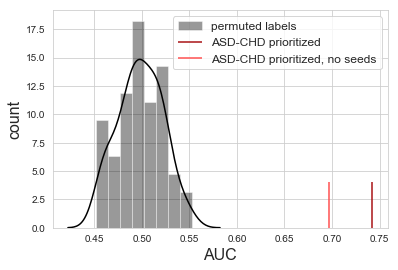

In [16]:
from scipy.stats import norm
# from scipy.special import ndtr
sns.distplot(auc_both_rand,label='permuted labels',color='k')
z_both = (auc_both-np.mean(auc_both_rand))/np.std(auc_both_rand)
print(z_both)
print(norm.sf(z_both))
z_both_noseeds = (auc_both_noseeds-np.mean(auc_both_rand))/np.std(auc_both_rand)
print(z_both_noseeds)
print(norm.sf(z_both_noseeds))
plt.vlines(auc_both,0,4,color='#A81012',label='ASD-CHD prioritized')
plt.vlines(auc_both_noseeds,0,4,color='#FF4F4F',label='ASD-CHD prioritized, no seeds')
plt.legend(loc='upper right',fontsize=12)
plt.xlabel('AUC',fontsize=16)
plt.ylabel('count',fontsize=16)
# plt.savefig('../../manuscript/figures_1911/DECIPHER_SNV_INDEL_AUC_'+str(dec_thresh)+'.png',dpi=300,bbox_inches='tight')

,FPR_both,FPR_both_noseeds,FPR_both_rand,TPR_both,TPR_both_noseeds,TPR_both_rand,thresh
96,0.039739,0.036992,0.019921,0.346405,0.224806,0.045752,3.026013


(0, 1.1)

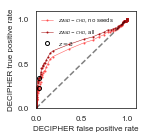

In [17]:
from sklearn.metrics import roc_curve,auc
sns.set_style('white')
threshlist = np.linspace(-17,400,2000)
ROC_df = pd.DataFrame({'thresh':threshlist,
                      'FPR_both':FPR_both,'TPR_both':TPR_both,
                      'FPR_both_noseeds':FPR_both_noseeds,'TPR_both_noseeds':TPR_both_noseeds,
                      'FPR_both_rand':FPR_both_rand,'TPR_both_rand':TPR_both_rand})
ROC_df.head()
plt.figure(figsize=(1.8,1.8))
plt.plot(FPR_both_noseeds,TPR_both_noseeds,'.-',color='#FF4F4F',label='$z_{ASD-CHD}$, no seeds',lw=.5,ms=2)
plt.plot(FPR_both,TPR_both,'.-',color='#A81012',label='$z_{ASD-CHD}$, all',lw=.5,ms=2)


# circle z=3 
ROC_z3 = ROC_df[(ROC_df['thresh']>2.9)&(ROC_df['thresh']<3.1)]
display(ROC_z3)
plt.plot(ROC_z3['FPR_both'],ROC_z3['TPR_both'],'o',ms=4,color='k',fillstyle='none',label='$z=3$')
plt.plot(ROC_z3['FPR_both_noseeds'],ROC_z3['TPR_both_noseeds'],'o',ms=4,color='k',fillstyle='none',label='')

# plt.plot(FPR_both_rand,TPR_both_rand,'k.-')
plt.plot([0,1],[0,1],'k--',alpha=.5)
plt.legend(loc='upper left', fontsize=6,frameon=False)
plt.xlabel('DECIPHER false positive rate',fontsize=8)
plt.ylabel('DECIPHER true positive rate',fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# plt.savefig('../../manuscript/figures_1911/Figure3/DECIPHER_SNV_INDEL_ROC_'+str(dec_thresh)+'.png',dpi=300,bbox_inches='tight')
# plt.savefig('../../manuscript/figures_1911/Figure3/DECIPHER_SNV_INDEL_ROC_'+str(dec_thresh)+'.pdf',dpi=300,bbox_inches='tight')
# plt.savefig('../../manuscript/figures_1911/Figure3/DECIPHER_SNV_INDEL_ROC_'+str(dec_thresh)+'.svg',dpi=300,bbox_inches='tight')

plt.xlim([0,1.1])
plt.ylim([0,1.1])